In [75]:
# Importing necessary libraries
import requests
import time
from tabulate import tabulate
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [76]:
# API Key
API_KEY = "9855691bd5526928ce2d62fec27145d2"

In [77]:
# Movies to compare against
TARGET_MOVIES = {
    "Inception": 27205,
    "The Dark Knight": 155,
    "Interstellar": 157336
}

In [78]:
def fetch_movie_details(movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={API_KEY}&append_to_response=credits,keywords"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        print(f"Fetched movie: {data.get('title')} (ID: {movie_id})")
        return {
            "title": data.get("title"),
            "genres": {genre["name"] for genre in data.get("genres", [])},
            "director": next((crew["name"] for crew in data["credits"]["crew"] if crew["job"] == "Director"), "Unknown"),
            "keywords": {keyword["name"] for keyword in data.get("keywords", {}).get("keywords", [])}, 
        }
    else:
        print(f"Error fetching movie ID {movie_id}: {response.status_code}")
        return None

In [80]:
# Fetch top-rated movies (limit to 50 pages = 4000 movies)
def fetch_top_movies(pages=200):
    all_movies = []
    for page in range(1, pages + 1):
        url = f"https://api.themoviedb.org/3/movie/top_rated?api_key={API_KEY}&page={page}"
        response = requests.get(url)
        if response.status_code == 200:
            all_movies.extend(response.json()["results"])
        else:
            print(f"Error fetching page {page}: {response.status_code}")
            break
    return all_movies



In [81]:
# Fetch details for target movies
target_movie_details = {name: fetch_movie_details(movie_id) for name, movie_id in TARGET_MOVIES.items()}
target_movie_details = {k: v for k, v in target_movie_details.items() if v is not None}

# Fetch top movies (limit to 1000)
top_movies = fetch_top_movies(pages=200)
print(f"Fetched {len(top_movies)} top-rated movies")

Fetched movie: Inception (ID: 27205)
Fetched movie: The Dark Knight (ID: 155)
Fetched movie: Interstellar (ID: 157336)
Fetched 4000 top-rated movies


In [82]:
print("Target movies successfully fetched:", list(target_movie_details.keys()))

Target movies successfully fetched: ['Inception', 'The Dark Knight', 'Interstellar']


In [83]:
# Fetch detailed info for each of the first 4000 movies 
detailed_movies = []
for movie in top_movies[:4000]:
    details = fetch_movie_details(movie["id"])
    if details:
        detailed_movies.append(details)
    time.sleep(0.2)

print(f"Fetched details for {len(detailed_movies)}")

Fetched movie: The Shawshank Redemption (ID: 278)
Fetched movie: The Godfather (ID: 238)
Fetched movie: The Godfather Part II (ID: 240)
Fetched movie: Schindler's List (ID: 424)
Fetched movie: 12 Angry Men (ID: 389)
Fetched movie: Spirited Away (ID: 129)
Fetched movie: The Dark Knight (ID: 155)
Fetched movie: Dilwale Dulhania Le Jayenge (ID: 19404)
Fetched movie: The Green Mile (ID: 497)
Fetched movie: Parasite (ID: 496243)
Fetched movie: Pulp Fiction (ID: 680)
Fetched movie: The Lord of the Rings: The Return of the King (ID: 122)
Fetched movie: Your Name. (ID: 372058)
Fetched movie: Forrest Gump (ID: 13)
Fetched movie: The Good, the Bad and the Ugly (ID: 429)
Fetched movie: Seven Samurai (ID: 346)
Fetched movie: GoodFellas (ID: 769)
Fetched movie: Interstellar (ID: 157336)
Fetched movie: Grave of the Fireflies (ID: 12477)
Fetched movie: Life Is Beautiful (ID: 637)
Fetched movie: Fight Club (ID: 550)
Fetched movie: Cinema Paradiso (ID: 11216)
Fetched movie: City of God (ID: 598)
Fetche

In [84]:
# Function to compute Jaccard Similarity 
def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0
    return len(set1 & set2) / len(set1 | set2)

In [85]:
# Compute similarity for each target movie
for target_name, target_details in target_movie_details.items():
    if not target_details:
        continue 

    similarity_scores = []
    for movie in detailed_movies:
        if movie["title"] == target_details["title"]:
            continue  

        score = jaccard_similarity(target_details["genres"], movie["genres"]) * 0.6 + \
                jaccard_similarity(target_details["keywords"], movie["keywords"]) * 0.3 + \
                (1 if target_details["director"] == movie["director"] else 0) * 0.1  

        similarity_scores.append((movie["title"], score))

    # Sort movies by similarity score
    similar_movies = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Print results in a table format
    print(f"\nTop 10 Movies Similar to {target_name}:")
    
    # Prepare data for the table
    table_data = [(title, f"{score:.2f}") for title, score in similar_movies[:10]]
    
    # Print table using tabulate
    print(tabulate(table_data, headers=["Movie Title", "Similarity Score"], tablefmt="grid"))



Top 10 Movies Similar to Inception:
+-----------------------------------+--------------------+
| Movie Title                       |   Similarity Score |
+===================================+====================+
| Iron Man                          |               0.61 |
+-----------------------------------+--------------------+
| Black Widow                       |               0.61 |
+-----------------------------------+--------------------+
| X-Men: First Class                |               0.61 |
+-----------------------------------+--------------------+
| Ready Player One                  |               0.61 |
+-----------------------------------+--------------------+
| Avengers: Endgame                 |               0.61 |
+-----------------------------------+--------------------+
| Ant-Man                           |               0.61 |
+-----------------------------------+--------------------+
| Mad Max: Fury Road                |               0.61 |
+------------------

In [ ]:
# Create Movie Profiles for Clustering
def create_movie_profile(movie):
    genres = ' '.join(movie['genres']) if movie['genres'] else ''
    keywords = ' '.join(movie['keywords']) if movie['keywords'] else ''
    director = movie['director'].replace(' ', '') if movie['director'] != 'Unknown' else ''
    return f"{genres} {keywords} {director}"

movies_list = []
for idx, movie in enumerate(detailed_movies):
    profile = create_movie_profile(movie)
    movies_list.append({
        "title": movie["title"],
        "profile": profile,
        "original_index": idx
    })

movie_profiles_df = pd.DataFrame(movies_list)
print(f"Created profiles for {len(movie_profiles_df)} movies")

Created profiles for 4000 movies


In [99]:
def show_cluster_for_movie(movie_title, movie_profiles_df, kmeans_model):
    # Find the movie in the DataFrame
    movie_row = movie_profiles_df[movie_profiles_df['title'] == movie_title]
    
    if movie_row.empty:
        print(f"{movie_title} not found in movie list.")
        return
    
    # Get the cluster ID
    cluster_id = movie_row.iloc[0]['cluster']
    
    # Get all movies in that cluster
    cluster_movies = movie_profiles_df[movie_profiles_df['cluster'] == cluster_id]
    
    # Print results
    print(f"\nCluster {cluster_id}: Movies similar to {movie_title}")
    print(cluster_movies[['title']].head(20).to_string(index=False))
    

In [87]:
# Vectorize Profiles
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(movie_profiles_df['profile'])

In [88]:
# Applying K-Mean Clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X)

# Add cluster labels
movie_profiles_df['cluster'] = kmeans.labels_


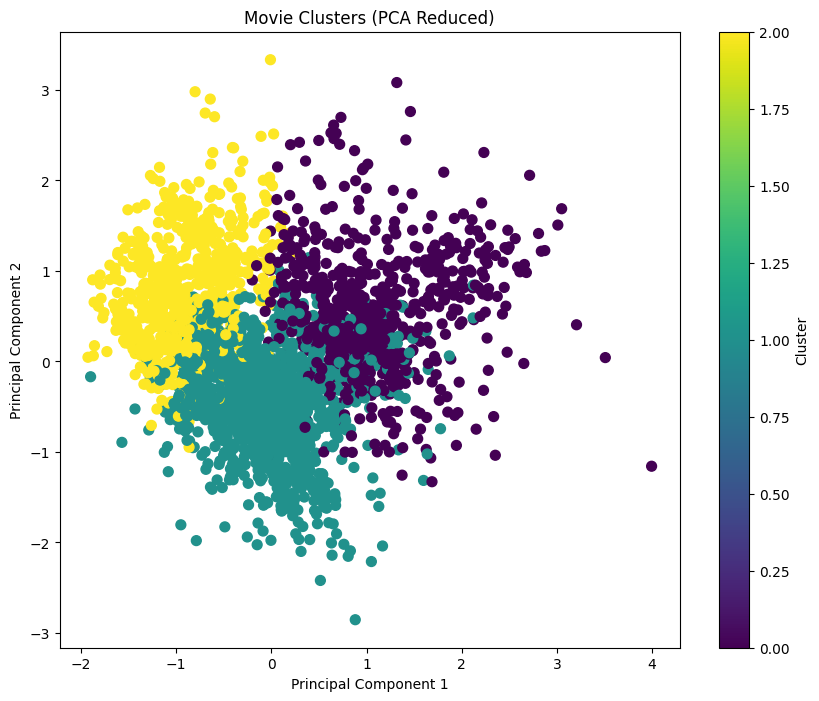

In [94]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.title("Movie Clusters (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster')
plt.show()

In [100]:
# Show cluster for each query movie
show_cluster_for_movie("Inception", movie_profiles_df, kmeans) 
show_cluster_for_movie("The Dark Knight", movie_profiles_df, kmeans)
show_cluster_for_movie("Interstellar", movie_profiles_df, kmeans)



Cluster 2: Movies similar to Inception
                                            title
                                    Spirited Away
    The Lord of the Rings: The Return of the King
                                     Interstellar
The Lord of the Rings: The Fellowship of the Ring
            The Lord of the Rings: The Two Towers
                Spider-Man: Into the Spider-Verse
                             Howl's Moving Castle
                          The Empire Strikes Back
                        A Silent Voice: The Movie
                        Primal: Tales of Savagery
                                        Inception
                                The Legend of Hei
              Spider-Man: Across the Spider-Verse
                         Dou kyu sei – Classmates
                                Princess Mononoke
             The Quintessential Quintuplets Movie
                                   The Wild Robot
                               Back to the Future
          

In [101]:
# Show top keywords in each cluster
common_keywords_per_cluster = []

for i in range(num_clusters):
    cluster_profiles = movie_profiles_df[movie_profiles_df['cluster'] == i]['profile']
    all_words = ' '.join(cluster_profiles).split()
    word_counts = pd.Series(all_words).value_counts().head(10)
    common_keywords_per_cluster.append(word_counts.index.tolist())

print("\nCommon keywords per cluster:")
for idx, keywords in enumerate(common_keywords_per_cluster):
    print(f"Cluster {idx}: {', '.join(keywords)}")


Common keywords per cluster:
Cluster 0: on, based, Drama, or, novel, book, story, true, relationship, of
Cluster 1: Drama, Comedy, relationship, Thriller, Romance, of, Crime, Action, love, war
Cluster 2: Animation, Adventure, Family, Action, on, based, Fantasy, Comedy, Fiction, Science
